In [2]:
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense


2023-10-17 06:44:19.369307: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-17 06:44:19.412055: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 06:44:20.039061: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# 데이터 만들기

In [4]:
# "raw" 폴더 안의 JSON 파일 목록을 가져옵니다.
data_dir = 'raw'
data_files = [file for file in os.listdir(data_dir) if file.endswith('.json')]

reviews = []
ratings = []

# 각 파일을 순회하며 데이터를 불러옵니다.
for data_file in data_files:
    with open(os.path.join(data_dir, data_file), 'r', encoding='utf-8') as file:
        data = json.load(file)
        for item in data:
            review = item.get('review')
            rating = item.get('rating')  # 문자열로 저장된 평점
            if review and rating is not None:
                reviews.append(review)
                # 이진 분류를 위한 처리: 문자열 평점을 정수로 변환하고 임계값 설정 (예: 5 이상을 긍정, 4 이하를 부정)
                rating = int(rating)
                binary_rating = 1 if rating >= 6 else 0
                ratings.append(binary_rating)

In [7]:
ratings[:10]

[1, 0, 1, 0, 1, 1, 1, 0, 1, 0]

In [93]:
# 훈련 및 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(reviews, ratings, test_size=0.2, random_state=42)

In [94]:
# 텍스트 데이터를 정수 시퀀스로 변환
max_words = 10000  # 사용할 최대 단어 수
max_length = 100  # 시퀀스의 최대 길이

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

X_train_sequences = pad_sequences(X_train_sequences, maxlen=max_length)
X_val_sequences = pad_sequences(X_val_sequences, maxlen=max_length)

In [106]:
y_train = np.expand_dims(y_train, axis=-1)  # Reshape to (None, 100, 1)
y_val = np.expand_dims(y_val, axis=-1)      # Reshape to (None, 100, 1)

In [109]:
y_val

array([[1],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [112]:
# 모델 아키텍처 정의
def build_model(model_type):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_length))
    
    if model_type == "RNN":
        model.add(LSTM(64, return_sequences=True))
    elif model_type == "LSTM":
        model.add(LSTM(64, return_sequences=True))
    elif model_type == "GRU":
        model.add(GRU(64, return_sequences=True))
    
    # 아웃풋
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [114]:
import time

model_types = ["RNN", "LSTM", "GRU"]

for model_type in model_types:
    model = build_model(model_type)
    
    # 옵티마이저
    optimizer = Adam(learning_rate=learning_rates[model_type])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    X_train_sequences = np.array(X_train_sequences) # 어레이 맞추기
    X_val_sequences = np.array(X_val_sequences)
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    
    start_time = time.time()  # 시작시간
    
    history = model.fit(X_train_sequences, y_train, validation_data=(X_val_sequences, y_val), epochs=5, batch_size=64)
    
    end_time = time.time()  # 종료시간
    
    training_time = end_time - start_time  # 학습 시간
    
    # 학습 시간 출력

    print(f"{model_type} Learning Rate: {learning_rates[model_type]}")
    print(f"{model_type} Training Time: {training_time} seconds")
    
    # Save the model
    model.save(f"{model_type}_model.h5")


Epoch 1/5
8905/8905 [==============================] - 787s 88ms/step - loss: 0.5150 - accuracy: 0.7877 - val_loss: 0.5125 - val_accuracy: 0.7885
Epoch 2/5
8905/8905 [==============================] - 754s 85ms/step - loss: 0.5135 - accuracy: 0.7881 - val_loss: 0.5122 - val_accuracy: 0.7887
Epoch 3/5
8905/8905 [==============================] - 745s 84ms/step - loss: 0.5125 - accuracy: 0.7884 - val_loss: 0.5121 - val_accuracy: 0.7887
Epoch 4/5
8905/8905 [==============================] - 747s 84ms/step - loss: 0.5118 - accuracy: 0.7887 - val_loss: 0.5121 - val_accuracy: 0.7887
Epoch 5/5
8274/8905 [==========================>...] - ETA: 49s - loss: 0.5109 - accuracy: 0.7891

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8905/8905 [==============================] - 207s 23ms/step - loss: 0.5150 - accuracy: 0.7875 - val_loss: 0.5126 - val_accuracy: 0.7885
Epoch 2/5
8905/8905 [==============================] - 183s 21ms/step - loss: 0.5135 - accuracy: 0.7880 - val_loss: 0.5127 - val_accuracy: 0.7885
Epoch 3/5
8905/8905 [==============================] - 183s 21ms/step - loss: 0.5134 - accuracy: 0.7881 - val_loss: 0.5125 - val_accuracy: 0.7885
Epoch 4/5
8905/8905 [==============================] - 182s 20ms/step - loss: 0.5132 - accuracy: 0.7881 - val_loss: 0.5154 - val_accuracy: 0.7885
Epoch 5/5
8905/8905 [==============================] - 182s 20ms/step - loss: 0.5132 - accuracy: 0.7881 - val_loss: 0.5131 - val_accuracy: 0.7885
LSTM Learning Rate: 0.01
LSTM Training Time: 937.5126168727875 seconds
Epoch 1/5
8905/8905 [==============================] - 196s 22ms/step - loss: 0.5175 - accuracy: 0.7866 - val_loss: 0.5127 - val_accuracy: 0.7885
Epoch 2/5
8905/8905 [==============================] - 173s 19m

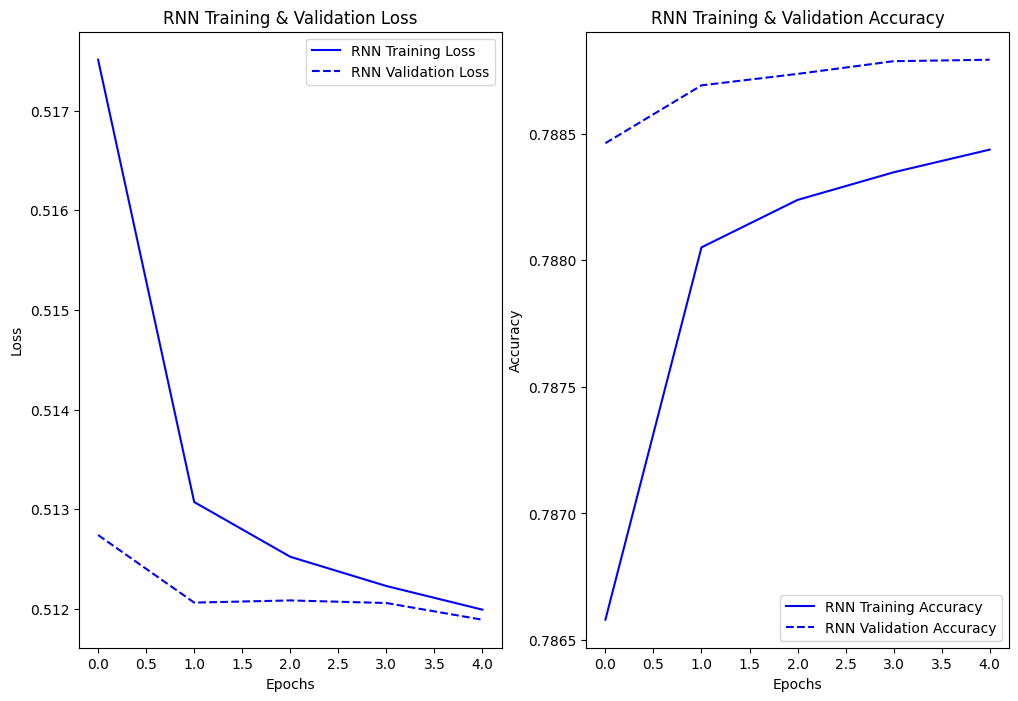

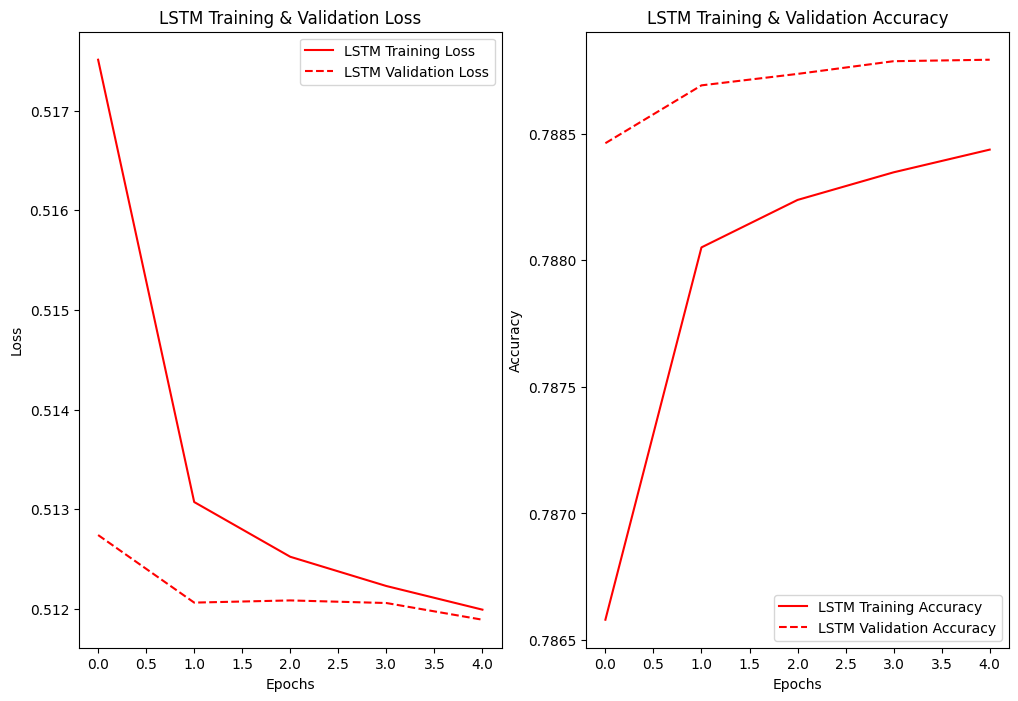

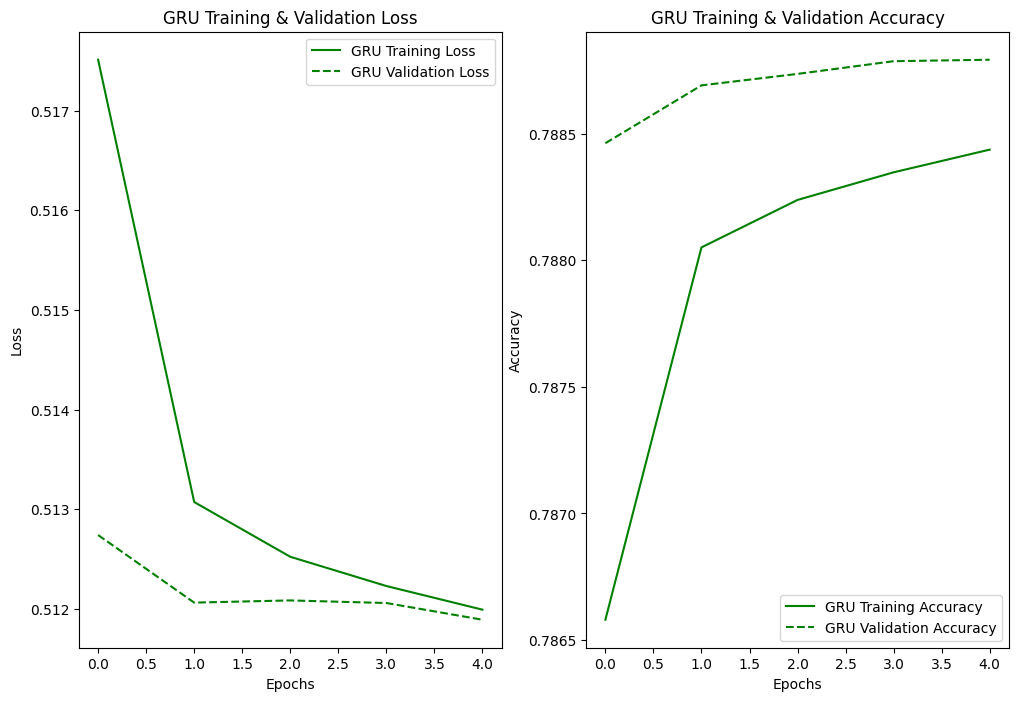

In [124]:
import matplotlib.pyplot as plt
import tensorflow.keras as keras

colors = ['blue', 'red', 'green']  # Colors for the three models
model_types = ["RNN", "LSTM", "GRU"]  # Model types

for i, model_type in enumerate(model_types):
    # Load the model
    model = keras.models.load_model(f"{model_type}_model.h5")

    # Evaluate the model on the validation data
    loss, accuracy = model.evaluate(X_val_sequences, y_val, verbose=0)

    # Create a new figure for each model
    plt.figure(figsize=(12, 8))

    # Plot training and validation loss for the current model
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label=f'{model_type} Training Loss', color=colors[i])
    plt.plot(history.history['val_loss'], label=f'{model_type} Validation Loss', linestyle='dashed', color=colors[i])
    plt.title(f'{model_type} Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy for the current model
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label=f'{model_type} Training Accuracy', color=colors[i])
    plt.plot(history.history['val_accuracy'], label=f'{model_type} Validation Accuracy', linestyle='dashed', color=colors[i])
    plt.title(f'{model_type} Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

# Show all the individual plots
plt.show()


[[0.7865803241729736,
  0.7880508899688721,
  0.7882383465766907,
  0.7883474230766296,
  0.7884370684623718],
 [0.7865803241729736,
  0.7880508899688721,
  0.7882383465766907,
  0.7883474230766296,
  0.7884370684623718],
 [0.7865803241729736,
  0.7880508899688721,
  0.7882383465766907,
  0.7883474230766296,
  0.7884370684623718]]